In [1]:
import mdtraj as md 
from ase import Atoms
from nglview import show_ase
import networkx as nx

import torch
import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader
from torch_geometric.nn import  GCNConv,BatchNorm
import torch_geometric.data as data
from torch_geometric.utils.convert import to_networkx

import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.preprocessing import MinMaxScaler

In [2]:
# load alanine dipeptide trajectory 
molecule = md.load_pdb("../simulation/single.pdb")

In [3]:
atomic_nums = [atom.element.atomic_number for atom in molecule.top.atoms] 
water = Atoms(positions= molecule.xyz[0], numbers=atomic_nums)
show_ase(water)

NGLWidget()

In [4]:
molecule.xyz*10

array([[[ 0.        ,  0.        ,  0.        ],
        [ 0.957     ,  0.        ,  0.        ],
        [-0.23900001,  0.926     ,  0.        ],
        [ 0.        ,  0.46      ,  0.32000002]]], dtype=float32)

In [5]:
def rotate3D(features,psi,theta,phi):
    xyz = features[:,:3]
    rest = features[:,3:]
    matrix = np.array([[np.cos(psi)*np.cos(phi)-np.cos(theta)*np.sin(phi)*np.sin(psi),np.cos(psi)*np.sin(phi)+np.cos(theta)*np.cos(phi)*np.sin(psi),np.sin(psi)*np.sin(theta)],
                          [-np.sin(psi)*np.cos(phi)-np.cos(theta)*np.sin(phi)*np.cos(psi),-np.sin(psi)*np.sin(phi)+np.cos(theta)*np.cos(phi)*np.cos(psi),np.cos(psi)*np.sin(theta)],
                            [np.sin(theta)*np.sin(phi),-np.sin(theta)*np.cos(phi),np.cos(theta)]])
    return np.concatenate((np.dot(xyz,matrix) *10 , rest),axis=1) 

In [6]:

# atomic Number
atomic_nums = np.array([[atom.element.atomic_number for atom in molecule.top.atoms]]).T

# Vander wall Radii
vdwr = np.array([[atom.element.radius for atom in molecule.top.atoms]]).T

# Atomic Mass 
mass = np.array([[atom.element.mass for atom in molecule.top.atoms]]).T

atom_type = np.array([[2,1,1,0]]).T

# Relative position of atoms on one molecule
poitions = molecule.xyz[0]*10
# calculate weighted average of the positions of the atoms in the molecule
com = np.average(poitions, axis=0, weights=mass.T[0])
# relative position of atoms in the molecule

relative_pos = poitions-com


print("Absolute positions:\n",poitions)
print("\nRelative positions:\n",relative_pos)
print("\natomic_numbers:\n",atomic_nums)
print("\nVander wall Radii:\n", vdwr)
print("\nAtomic Mass:\n",mass)

Absolute positions:
 [[ 0.          0.          0.        ]
 [ 0.957       0.          0.        ]
 [-0.23900001  0.926       0.        ]
 [ 0.          0.46        0.32000002]]

Relative positions:
 [[-0.04017169 -0.05180917  0.        ]
 [ 0.91682833 -0.05180917  0.        ]
 [-0.27917169  0.87419083  0.        ]
 [-0.04017169  0.40819084  0.32000002]]

atomic_numbers:
 [[8]
 [1]
 [1]
 [0]]

Vander wall Radii:
 [[0.152]
 [0.12 ]
 [0.12 ]
 [0.   ]]

Atomic Mass:
 [[15.99943 ]
 [ 1.007947]
 [ 1.007947]
 [ 0.      ]]


In [7]:
node_features = np.concatenate((relative_pos,vdwr,atom_type),axis=1)
print("Node Features:\n",node_features)

Node Features:
 [[-0.04017169 -0.05180917  0.          0.152       2.        ]
 [ 0.91682833 -0.05180917  0.          0.12        1.        ]
 [-0.27917169  0.87419083  0.          0.12        1.        ]
 [-0.04017169  0.40819084  0.32000002  0.          0.        ]]


In [8]:
normalized_node_features = (node_features - node_features.min(axis=0))/(node_features.max(axis=0)-node_features.min(axis=0))
print("Normalized Node Features:\n",normalized_node_features)

Normalized Node Features:
 [[0.19983278 0.         0.         1.         1.        ]
 [1.         0.         0.         0.78947368 0.5       ]
 [0.         1.         0.         0.78947368 0.5       ]
 [0.19983278 0.49676027 1.         0.         0.        ]]


In [9]:
from_list = []
to_list = []
for edge in molecule.topology.bonds:
  from_list.append(edge.atom1.index)
  to_list.append(edge.atom2.index)
  from_list.append(edge.atom2.index)
  to_list.append(edge.atom1.index)

edge_list = np.array([from_list,to_list])

In [10]:
graph = data.Data(x=torch.from_numpy(normalized_node_features),edge_index=torch.from_numpy(edge_list))

In [11]:
print(graph)

Data(x=[4, 5], edge_index=[2, 4])


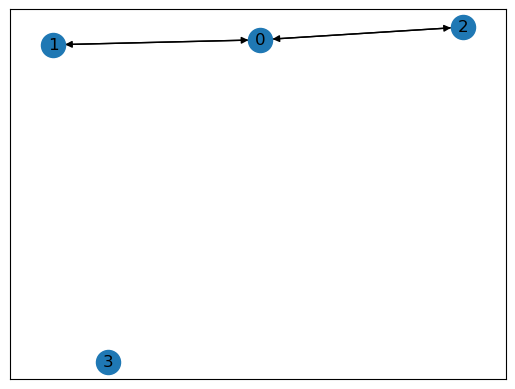

In [12]:
vis = to_networkx(graph)
nx.draw_networkx(vis)

In [13]:
def convert_to_adj(edge_index, num_nodes=None):
    if num_nodes is None:
        num_nodes = edge_index.max() + 1
    adj = torch.zeros(num_nodes, num_nodes)
    adj[edge_index[0], edge_index[1]] = 1
    return adj

def convert_to_edge_index(adj):
    edge_index = adj.nonzero().t()
    return edge_index

In [14]:
graphs = []
n_graphs = 5000

In [15]:
all_features = []
real_node_features = []

for i in range(n_graphs):
    rotated = rotate3D(node_features,np.random.uniform(0,2*np.pi),np.random.uniform(0,2*np.pi),np.random.uniform(0,2*np.pi))
    real_node_features.append(rotated)

    noisy_node_features = rotated + np.random.normal(0,0.1,rotated.shape)

    all_features.append(noisy_node_features)
    real_node_features.append(rotated)

all_features = np.array(all_features)    
real_node_features = np.array(real_node_features)

In [16]:
scaler = MinMaxScaler()
scaler.fit(all_features.reshape(-1,1))
normalized_node_features = scaler.transform(all_features.reshape(-1,1)).reshape(all_features.shape)

normalized_real_node_features = scaler.transform(real_node_features.reshape(-1,1)).reshape(real_node_features.shape)


In [17]:
for x,y in zip(normalized_node_features,normalized_real_node_features):
    graph = data.Data(x=torch.from_numpy(x),edge_index=torch.from_numpy(edge_list),y=torch.from_numpy(y))
    graphs.append(graph)
    

In [18]:
graphs[0]

Data(x=[4, 5], edge_index=[2, 4], y=[4, 5])

In [19]:
graphs

[Data(x=[4, 5], edge_index=[2, 4], y=[4, 5]),
 Data(x=[4, 5], edge_index=[2, 4], y=[4, 5]),
 Data(x=[4, 5], edge_index=[2, 4], y=[4, 5]),
 Data(x=[4, 5], edge_index=[2, 4], y=[4, 5]),
 Data(x=[4, 5], edge_index=[2, 4], y=[4, 5]),
 Data(x=[4, 5], edge_index=[2, 4], y=[4, 5]),
 Data(x=[4, 5], edge_index=[2, 4], y=[4, 5]),
 Data(x=[4, 5], edge_index=[2, 4], y=[4, 5]),
 Data(x=[4, 5], edge_index=[2, 4], y=[4, 5]),
 Data(x=[4, 5], edge_index=[2, 4], y=[4, 5]),
 Data(x=[4, 5], edge_index=[2, 4], y=[4, 5]),
 Data(x=[4, 5], edge_index=[2, 4], y=[4, 5]),
 Data(x=[4, 5], edge_index=[2, 4], y=[4, 5]),
 Data(x=[4, 5], edge_index=[2, 4], y=[4, 5]),
 Data(x=[4, 5], edge_index=[2, 4], y=[4, 5]),
 Data(x=[4, 5], edge_index=[2, 4], y=[4, 5]),
 Data(x=[4, 5], edge_index=[2, 4], y=[4, 5]),
 Data(x=[4, 5], edge_index=[2, 4], y=[4, 5]),
 Data(x=[4, 5], edge_index=[2, 4], y=[4, 5]),
 Data(x=[4, 5], edge_index=[2, 4], y=[4, 5]),
 Data(x=[4, 5], edge_index=[2, 4], y=[4, 5]),
 Data(x=[4, 5], edge_index=[2, 4],

In [21]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GraphUNet
from torch_geometric.data import Data
input_dim=graph.x.size(-1)
output_dim=graph.y.size(-1)
hidden_channels=32
depth=3

In [22]:
graph.num_features

5

In [23]:
model=GraphUNet(input_dim, hidden_channels, output_dim,depth)


In [24]:
output = model(graph.x.float(), graph.edge_index)


ImportError: 'SparseTensor' requires 'torch-sparse'

In [26]:
graph.x.size(-1)

5